In [231]:
# Warning: usually don't do this kind of inclusion : using *, you 'merge' the namespaces
#          but in this case we actually want to mimic the imports as if they were imported here
from src.setup import *
from Pyhattan import FormatData, GenerateManhattan
import scipy.stats as stats

# This prevents to restart the kernel whenever an external file is edited
%load_ext autoreload
%autoreload 2

from src import common
from src import host

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

At this point, we expect to have **clean** viral and host data (filtered for missingness, rare variants, hardy-weinberg equilibrium). We also assume that there is a file containing all the individuals (IGM ids) that are in all the datasets (we will use this together with `--keep-fam` command of plink).

We will first filter out the individuals that are missing in any of the three datasets (viral sequencing data, host sequencing data, clinical data) by using a custom function `common.find_individuals`. Then we will run some PCAs and association tests (univariate and multivariate models, i.e. corrected for sex, age, population stratification, ...). Eventually, we'll focus on asian individuals.

## Method

We use a custom `host.plot_plink_pca` function that looks at the plink PCA data and automatically merges a variable of the clinical data.

# Principal component analysis

We want to **exclude the chromosomes 6, X and Y**. We first compute the PCA for all individuals, then for asian people.

## plink PCA computation

We use the `--keep-fam <file>` command to keep individuals that are in all datasets. 

In [4]:
host.run_plink("--pca --keep-fam " + PATH_INTERSECTING_INDIVIDUALS+" --not-chr 0 6 X Y XY",
                file=PATH_HOST_CLEAN_DATA, out=PATH_HOST_CLEAN_DATA,
                extension='eigenvec', log_name='host_pca', force=True);

Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --pca --keep-fam data/individuals/intersecting_ids --not-chr 0 6 X Y XY '
Log written to 'data/plink/log/host_pca.log'


## All individuals


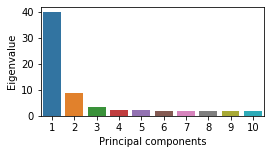

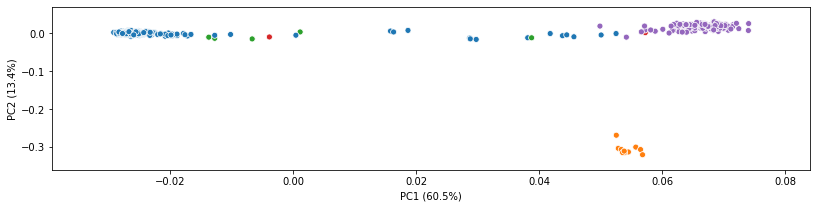

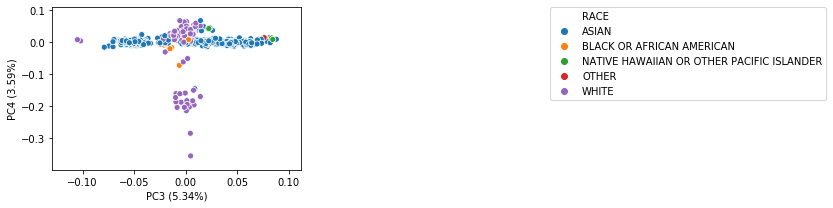

In [6]:
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='RACE',
                   bbox_to_anchor=(2, 1))

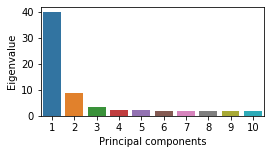

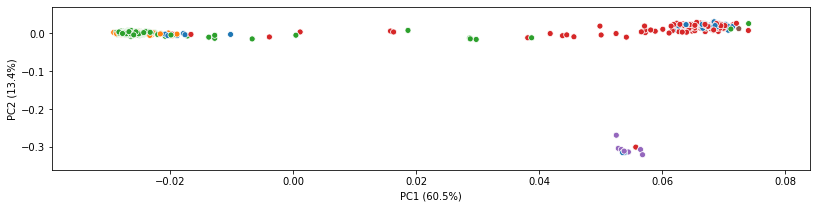

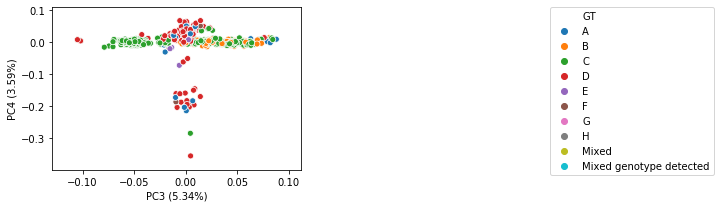

In [7]:
host.plot_plink_pca(PATH_HOST_CLEAN_DATA, n_pcs=4, hue_col='GT',
                   bbox_to_anchor=(2, 1))

# Association analyses

Starting from now, all the computations are done with `PATH_WORKING_DATASET` defined in `setup.py` so make sure this variable targets the right dataset.

We will make use of the `write_phenotypes` function to create a file that plink can read as phenotypes. Plink sees phenotypes as response variable / outcome of a regression or association model. 

## Simple univariate model

### BMI

In [229]:
pheno = 'BASELINE_BMI'

In [230]:
# We write the BMI of asian individuals
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype=pheno, 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES)
o, e = host.run_assoc()

/home/mazeller/.local/lib/python3.6/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


440 individuals written to 'data/working_pheno'
170 were filtered out based on the criteria ('RACE', 'ASIAN')
The phenotype 'BASELINE_BMI' was included.
Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --keep data/working_pheno --linear --pheno data/working_pheno '


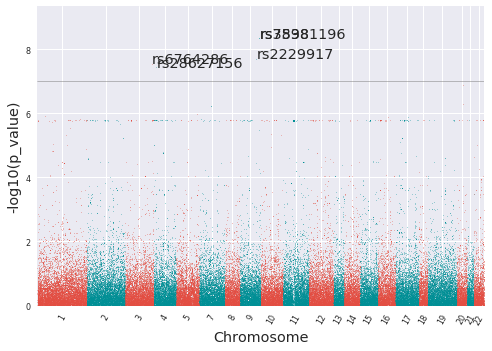

In [227]:
data = FormatData(PATH_HOST_CLEAN_DATA+'.BASELINE_BMI.glm.linear', sep='\s+', chromosome='#CHROM', 
                  p_value='P')
GenerateManhattan(data, refSNP='ID', significance=7)

In [235]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.BASELINE_BMI.glm.linear', sep='\s+',
                 usecols=['P'])
#df['-log10P'] = df.P.apply(lambda x: - np.log10(x))

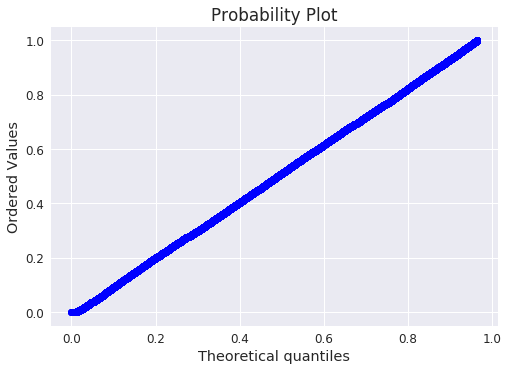

In [256]:
stats.probplot(df['P'], dist='uniform', plot=plt);

### Random vectors N(0, 1)

In [259]:
common.write_phenotypes(PATH_HOST_CLEAN_DATA, phenotype='random', 
                        criteria=('RACE', 'ASIAN'), output_path=PATH_WORKING_PHENOTYPES)
o, e = host.run_assoc()
#print(o)

/home/mazeller/.local/lib/python3.6/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


440 individuals written to 'data/working_pheno'
170 were filtered out based on the criteria ('RACE', 'ASIAN')
The phenotype 'random' was included.
Running 'plink2 --bfile data/plink/host_geno_clean --out data/plink/host_geno_clean --not-chr 0 6 X Y XY MT --keep data/working_pheno --linear --pheno data/working_pheno '


In [261]:
df = pd.read_csv(PATH_HOST_CLEAN_DATA+'.1.glm.linear', sep='\s+',
                 usecols=['P'])

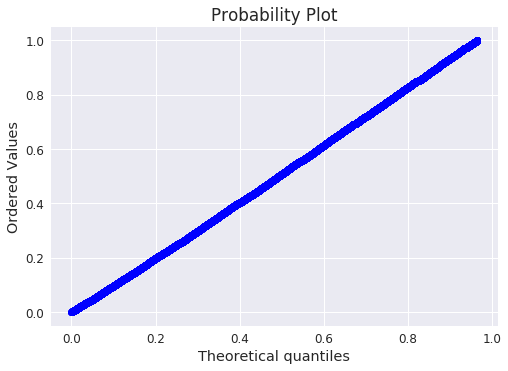

In [262]:
stats.probplot(df['P'], dist='uniform', plot=plt);